# Setup

In [80]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from src.visualization.tex_tables import latex_table_generator_comparison, latex_table_generator, \
        latex_table_generator_multirow
from src.visualization.plots import make_pointplot, make_boxplot, make_barplot, make_heatmap, \
        highlight_pos

In [81]:
sns.set()

# Visualizations - Model Selection

We will find most optimal model from our parameters grid.

In [82]:
results = pd.read_csv(r'results\result_choose_model_params.csv', index_col=['Unnamed: 0'])
scores = ['accuracy', 'recall', 'precision', 'F1_score']

for score in scores:
    results[score] = results[score].apply(eval)

params = {'n_samples':[20, 100, 200],
          'n_mfcc':[13],
          'hop_wins':[0.01, 0.03, 0.05],
          'len_wins':[0.025, 0.04],
          'n_iters':[15, 30, 50],
          'n_hiddens':[4, 6, 12]}

ints = ['n_samples', 'n_mfcc', 'n_iter', 'n_hidden']
numeric = ['hop_win', 'len_win']
lists = ['accuracy', 'recall', 'precision', 'F1_score']

results[ints] = results[ints].astype('int64')
results[numeric] = results[numeric].astype('float64')
for i in lists:
    results[i] = results[i].apply(lambda x: np.round(x, 3))    

results.head()

,n_samples,n_mfcc,hop_win,len_win,n_iter,n_hidden,accuracy,recall,precision,F1_score
0,20,13,0.01,0.025,15,4,"[0.7, 0.7, 0.7, 0.7, 0.7]","[0.7, 0.7, 0.7, 0.7, 0.7]","[0.925, 0.883, 0.883, 0.883, 0.888]","[0.64, 0.617, 0.617, 0.617, 0.62]"
1,20,13,0.01,0.025,15,6,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
2,20,13,0.01,0.025,15,12,"[0.9, 0.9, 1.0, 1.0, 0.9]","[0.9, 0.9, 1.0, 1.0, 0.9]","[0.95, 0.95, 1.0, 1.0, 0.95]","[0.867, 0.867, 1.0, 1.0, 0.867]"
3,20,13,0.01,0.025,30,4,"[0.8, 0.7, 0.8, 0.8, 0.8]","[0.8, 0.7, 0.8, 0.8, 0.8]","[0.933, 0.883, 0.933, 0.933, 0.933]","[0.75, 0.617, 0.75, 0.75, 0.75]"
4,20,13,0.01,0.025,30,6,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"


In [83]:
# We will make an id column
# Because our rows contains columns with list in cell we will expand dataframe
# but simultaneously we want to keep information from which simulation was given result
results['id'] = results.index
results['k'] = results['n_samples'].apply(lambda x: [1, 2, 3, 4 ,5])
result_expand = results.explode(scores + ['k']).reset_index(drop=True)

## Chart 1

We will make a pointplot with different values of R and N_train for each score metric.

Conclusions:
- 20 observations - too less, model is underfitting
- 100 observations - optimal 
- 200 observations - sometimes model can overfit

Moreover:
- the smaller R the better resutls. It comes from the fact, that the smaller R the more information about data it conatins.

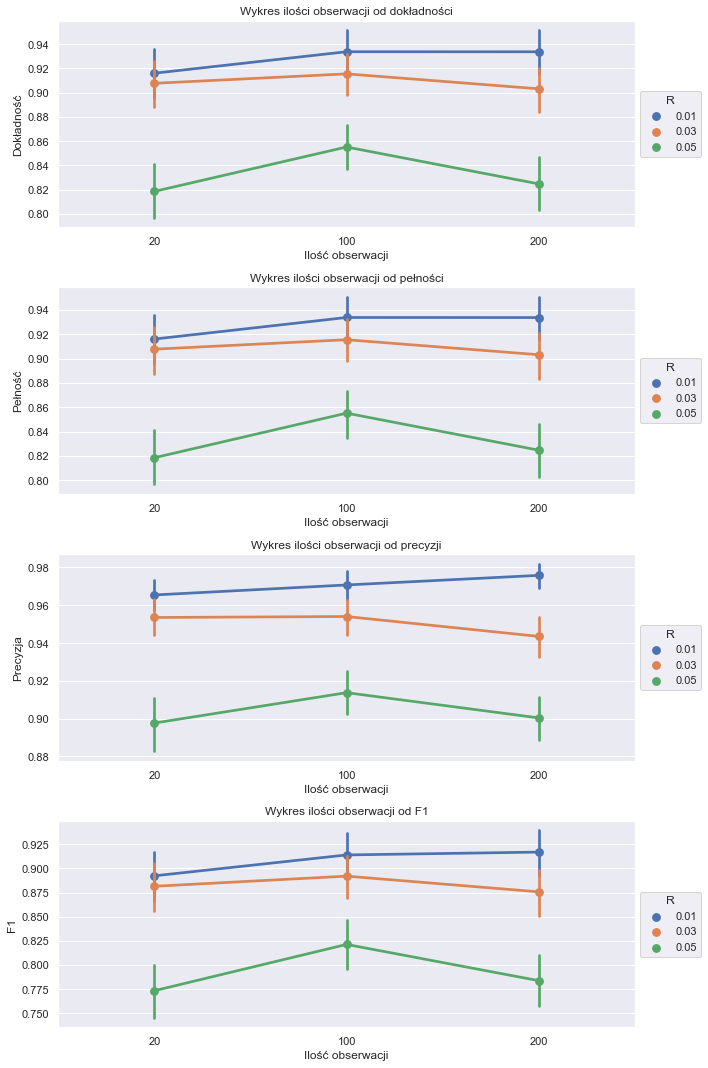

In [84]:
ylabels = ['Dokładność', 'Pełność', 'Precyzja', 'F1']
titles = ['dokładności', 'pełności', 'precyzji', 'F1']

fig = make_pointplot(result_expand, x='n_samples', hue='hop_win', 
               ylabels=ylabels,
               titles=titles,
               scores=scores, 
               legend_title='R', 
               title_x='ilości obserwacji',
               xlabel="Ilość obserwacji")

In [15]:
fig.savefig(r'vis\czyste_point_n_S_score.png')

## Table to Chart 1

We will create table of mean and std values with respect to R and S.

Conclusion:
- the most optimal values are R=0.01 and S=0.025 what is in accordance with theory.
- the mean values are the greatest then
- The lesser R and S the lesser is std, which means that model results are more stable

In [85]:
results_mean = results.copy()
for score in scores:
    results_mean[f'{score}_mean'] = results_mean[score].apply(lambda x: np.mean(x))
    results_mean[f'{score}_std'] = results_mean[score].apply(lambda x: np.std(x))    
results_mean = results_mean.drop(scores + ['k', 'n_mfcc', 'id'], axis=1)

### Table with mean

In [86]:
mask = results_mean['n_samples'] == 100
temp = results_mean[mask].groupby(['hop_win', 'len_win'])[[f'{score}_mean' for score in scores]].max()
temp

accuracy_mean  recall_mean  precision_mean  F1_score_mean
hop_win len_win                                                           
0.01    0.025            1.000        1.000          1.0000         1.0000
        0.040            1.000        1.000          1.0000         1.0000
0.03    0.025            0.984        0.984          0.9882         0.9832
        0.040            0.980        0.980          0.9900         0.9734
0.05    0.025            0.909        0.909          0.9360         0.8946
        0.040            0.954        0.954          0.9714         0.9436

#### Latex table

In [26]:
latex_table_generator_multirow(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'], ['R', 'S'], 2)

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{R} & \textbf{S} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}0.025 & 1.0 & 1.0 & 1.0 & 1.0\\ \cline{2-6} 
\multirow{-2}{*}{\cellcolor[HTML]{EFEFEF}0.01} & \cellcolor[HTML]{EFEFEF}0.04 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}0.025 & 0.984 & 0.984 & 0.988 & 0.983\\ \cline{2-6} 
\multirow{-2}{*}{\cellcolor[HTML]{EFEFEF}0.03} & \cellcolor[HTML]{EFEFEF}0.04 & 0.98 & 0.98 & 0.99 & 0.973\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}0.025 & 0.909 & 0.909 & 0.936 & 0.895\\ \cline{2-6} 
\multirow{-2}{*}{\cellcolor[HTML]{EFEFEF}0.05} & \cellcolor[HTML]{EFEFEF}0.04 & 0.954 & 0.954 & 0.971 & 0.944\\ \hline 
\end{tabular}
\caption{}
\label{tab:}
\end{table}


### Table with std

In [27]:
temp = results_mean[mask].groupby(['hop_win', 'len_win'])[[f'{score}_std' for score in scores]].min()
temp

accuracy_std  recall_std  precision_std  F1_score_std
hop_win len_win                                                       
0.01    0.025        0.000000    0.000000       0.000000      0.000000
        0.040        0.000000    0.000000       0.000000      0.000000
0.03    0.025        0.019849    0.019849       0.012123      0.021423
        0.040        0.002000    0.002000       0.006911      0.005426
0.05    0.025        0.035861    0.035861       0.020209      0.049447
        0.040        0.048000    0.048000       0.013401      0.055816

#### Latex table

In [28]:
latex_table_generator_multirow(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'], ['R', 'S'], 2)

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{R} & \textbf{S} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}0.025 & 0.0 & 0.0 & 0.0 & 0.0\\ \cline{2-6} 
\multirow{-2}{*}{\cellcolor[HTML]{EFEFEF}0.01} & \cellcolor[HTML]{EFEFEF}0.04 & 0.0 & 0.0 & 0.0 & 0.0\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}0.025 & 0.02 & 0.02 & 0.012 & 0.021\\ \cline{2-6} 
\multirow{-2}{*}{\cellcolor[HTML]{EFEFEF}0.03} & \cellcolor[HTML]{EFEFEF}0.04 & 0.002 & 0.002 & 0.007 & 0.005\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}0.025 & 0.036 & 0.036 & 0.02 & 0.049\\ \cline{2-6} 
\multirow{-2}{*}{\cellcolor[HTML]{EFEFEF}0.05} & \cellcolor[HTML]{EFEFEF}0.04 & 0.048 & 0.048 & 0.013 & 0.056\\ \hline 
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Chart 2 - Optimal Model parameters, continuation

We know that for N_train=100, R=0.01, and S=0.025 model is best for now. Lets find optimal n_hidden and n_iter parameters. We will make boxplots of hidden states with respect to number of itterations. 

Conclusions:
- Models mostly are better for n_hidden-6
- We observe more differentiation in results when n_hidden is greater than 6
- In average results are similar for n_hidden equal 4 and 12.

In [87]:
mask = results_mean['n_samples'] == 100

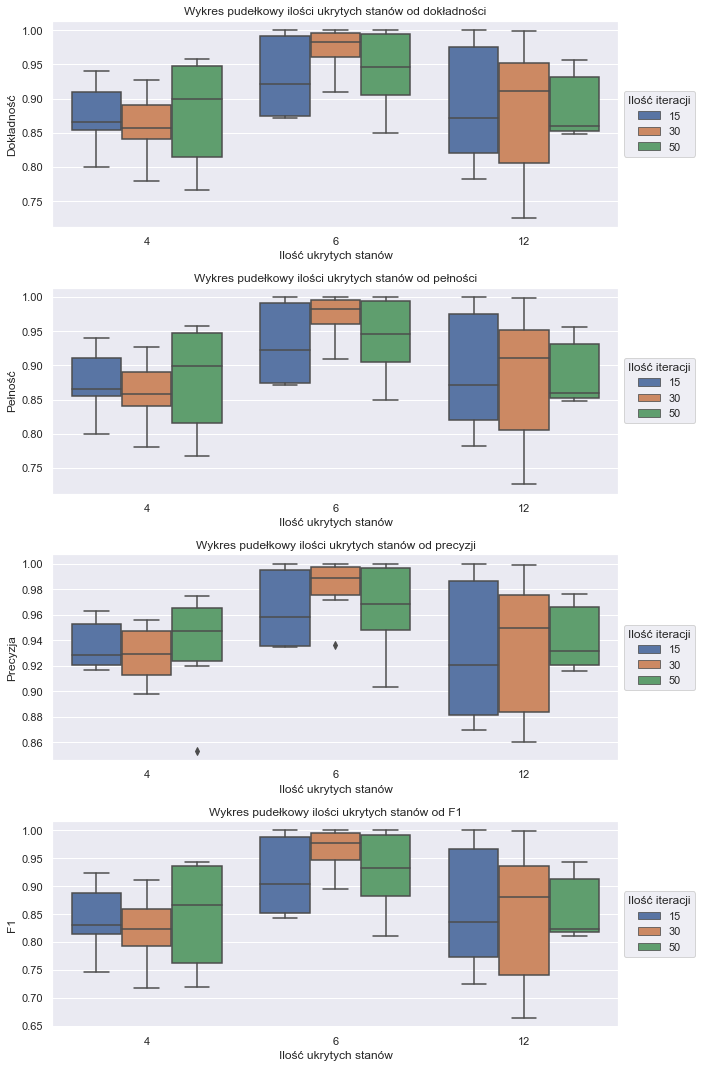

In [88]:
ylabels = ['Dokładność', 'Pełność', 'Precyzja', 'F1']
titles = ['dokładności', 'pełności', 'precyzji', 'F1']

fig = make_boxplot(results_mean[mask], x='n_hidden', hue='n_iter', 
               ylabels=ylabels,
               titles=titles,
               scores=scores, 
               legend_title='Ilość iteracji', 
               title_x='pudełkowy ilości ukrytych stanów',
               xlabel="Ilość ukrytych stanów")

In [23]:
fig.savefig(r'vis\czyste_box_hidden_iteracje.png')

## Tabel to chart 2

We will make tables of means and std for models with n=100, R=0.01, S=0.025 with respect to n)hidden and n_iter parameters.

Conclusions:
- for n_hidden=6 model has perfect scores
- from that right away results that their std is 0
- n_hidden=12 works slightly better than n_hidden=4
- it doesn't change the fact that in average it works worse than n_hidden=6
- we should note that for n_hidden=12 there is much more computation
- note that, the greater number of n_iter the worse the results are

In [89]:
mask = (results_mean['n_samples'] == 100) & (results_mean['hop_win'] == 0.01) & (results_mean['len_win'] == 0.025)

### Table with mean

In [90]:
temp = results_mean[mask].groupby(['n_hidden', 'n_iter'])[[f'{score}_mean' for score in scores]].max()
temp

accuracy_mean  recall_mean  precision_mean  F1_score_mean
n_hidden n_iter                                                           
4        15              0.800        0.800          0.9264         0.7466
         30              0.780        0.780          0.9098         0.7166
         50              0.800        0.800          0.9198         0.7432
6        15              1.000        1.000          1.0000         1.0000
         30              1.000        1.000          1.0000         1.0000
         50              1.000        1.000          1.0000         1.0000
12       15              1.000        1.000          1.0000         1.0000
         30              0.999        0.999          0.9990         0.9990
         50              0.954        0.954          0.9754         0.9406

#### Latex table

In [37]:
latex_table_generator_multirow(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'],
                               [r'\textit{n\_components}', r'\textit{n\_iter}'], 3)

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{\textit{n\_components}} & \textbf{\textit{n\_iter}} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}15 & 0.8 & 0.8 & 0.926 & 0.747\\ \cline{2-6} 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}30 & 0.78 & 0.78 & 0.91 & 0.717\\ \cline{2-6} 
\multirow{-3}{*}{\cellcolor[HTML]{EFEFEF}4} & \cellcolor[HTML]{EFEFEF}50 & 0.8 & 0.8 & 0.92 & 0.743\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}15 & 1.0 & 1.0 & 1.0 & 1.0\\ \cline{2-6} 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}30 & 1.0 & 1.0 & 1.0 & 1.0\\ \cline{2-6} 
\multirow{-3}{*}{\cellcolor[HTML]{EFEFEF}6} & \cellcolor[HTML]{EFEFEF}50 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}15 & 1.0 & 1.0 & 1.0 & 1.0\\ \cline{2-6} 
\cellcolor[HTML]{EFEFEF} & \cellcolor[HTML]{EFEFEF}30 & 0.999 & 0.

### Table with std

In [38]:
results_mean[mask].groupby(['n_hidden', 'n_iter'])[[f'{score}_std' for score in scores]].max()

accuracy_std  recall_std  precision_std  F1_score_std
n_hidden n_iter                                                       
4        15          0.000000    0.000000       0.013200      0.006800
         30          0.040000    0.040000       0.019934      0.050377
         50          0.000000    0.000000       0.016167      0.008328
6        15          0.000000    0.000000       0.000000      0.000000
         30          0.000000    0.000000       0.000000      0.000000
         50          0.000000    0.000000       0.000000      0.000000
12       15          0.000000    0.000000       0.000000      0.000000
         30          0.002000    0.002000       0.002000      0.002000
         50          0.045431    0.045431       0.022375      0.061151

## In conlusion

We shall choose the model with following parameters:
- n = 100
- R = 0.01
- S = 0.025
- n_iter = 15
- n_hidden = 6

# Visualizations -  Randomization

We may check how randomization of our dataset may affect results

In [93]:
params = {
    'random_horizontal_shift': [0.1, 0.25, 0.4],
    'random_vertical_scaling': [0.5, 1, 10],
    'n_iter' : [15, 30, 50],
    'n_hiddens': [5, 6, 7]
}

results = pd.read_csv(r'results\result_randomness.csv', 
                     index_col=['Unnamed: 0'])

ints = ['n_iter', 'n_hiddens']
numeric = ['random_horizontal_shift', 'random_vertical_scaling']
scores = ['accuracy', 'recall', 'precision', 'F1_score']

results[ints] = results[ints].astype('int64')
results[numeric] = results[numeric].astype('float64')
for i in scores:
    results[i] = results[i].apply(lambda x: np.round(x, 3))    

results['dataset_id'] = 1
i = 1
for rhs in params['random_horizontal_shift']:
    for rvs in params['random_vertical_scaling']:
        mask = (results['random_vertical_scaling'] == rvs) & (results['random_horizontal_shift'] == rhs)  
        results.loc[mask, 'dataset_id'] = i
        i += 1

## Chart 3

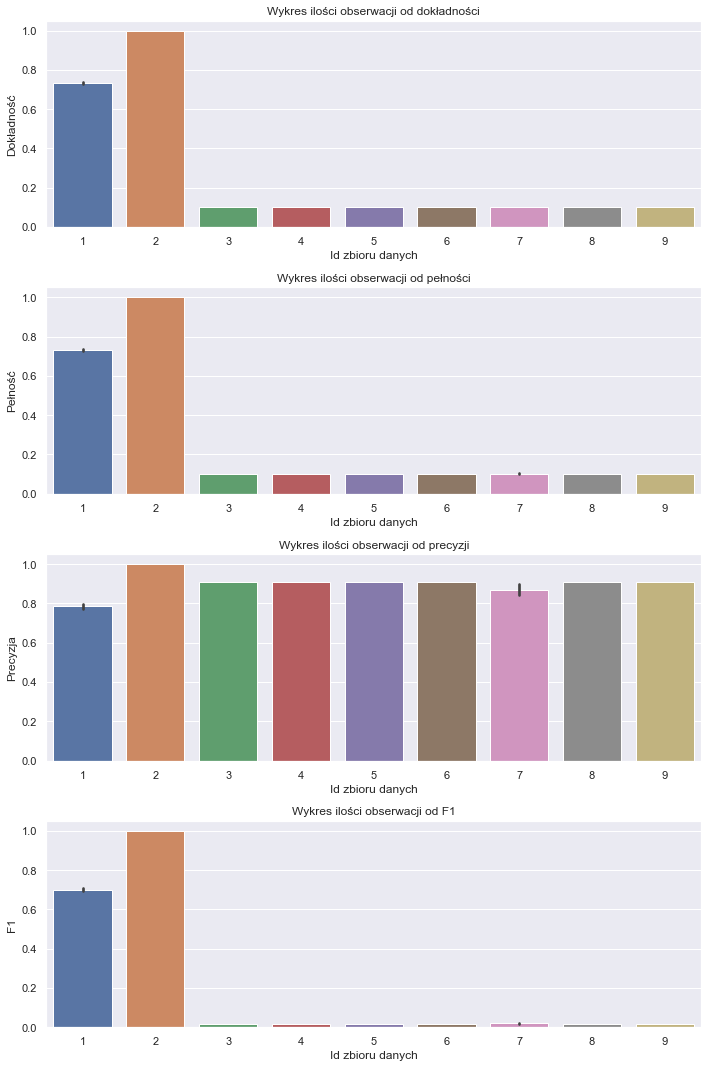

In [94]:
ylabels = ['Dokładność', 'Pełność', 'Precyzja', 'F1']
titles = ['dokładności', 'pełności', 'precyzji', 'F1']

fig = make_barplot(results, x='dataset_id', hue=None, 
               ylabels=ylabels,
               titles=titles,
               scores=scores, 
               title_x='ilości obserwacji',
               xlabel="Id zbioru danych")

# Visualizations - Noise

Now we can analyze results of our model in the presence of noise.

In [95]:
params = {
    'beta': [-2, -1, 0, 1, 2],
    'SNR': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'n_iters' : [15],
    'n_hiddens': [6]
}

results = pd.read_csv(r'results\result_noise.csv', 
                     index_col=['Unnamed: 0'])

ints = ['n_iter', 'n_hidden', 'beta', 'SNR']
scores = ['accuracy', 'recall', 'precision', 'F1_score']

results[ints] = results[ints].astype('int64')
for i in scores:
    results[i] = results[i].apply(lambda x: np.round(x, 3))    

## Tabel 1 SNR = 9

In [96]:
mask = results['SNR']==9
temp = results[mask].groupby(['beta'])[scores].max()
temp

,accuracy,recall,precision,F1_score
beta,,,,
-2,0.889,0.889,0.944,0.852
-1,0.889,0.889,0.944,0.852
0,0.889,0.889,0.944,0.852
1,1.000,1.000,1.000,1.000
2,1.000,1.000,1.000,1.000


### Latex Tabel

In [97]:
latex_table_generator(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'], [r'$\beta$'])

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{$\beta$} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF}-2 & 0.889 & 0.889 & 0.944 & 0.852\\ \hline 
\cellcolor[HTML]{EFEFEF}-1 & 0.889 & 0.889 & 0.944 & 0.852\\ \hline 
\cellcolor[HTML]{EFEFEF}0 & 0.889 & 0.889 & 0.944 & 0.852\\ \hline 
\cellcolor[HTML]{EFEFEF}1 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\cellcolor[HTML]{EFEFEF}2 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Tabel 2 SNR = -2

In [98]:
mask = results['SNR']==-2
temp = results[mask].groupby(['beta'])[scores].max()
temp

,accuracy,recall,precision,F1_score
beta,,,,
-2,0.183,0.183,0.632,0.106
-1,0.211,0.211,0.661,0.141
0,0.200,0.200,0.654,0.129
1,0.472,0.472,0.801,0.363
2,0.344,0.344,0.770,0.320


### Latex table

In [99]:
latex_table_generator(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'], [r'$\beta$'])

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{$\beta$} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF}-2 & 0.183 & 0.183 & 0.632 & 0.106\\ \hline 
\cellcolor[HTML]{EFEFEF}-1 & 0.211 & 0.211 & 0.661 & 0.141\\ \hline 
\cellcolor[HTML]{EFEFEF}0 & 0.2 & 0.2 & 0.654 & 0.129\\ \hline 
\cellcolor[HTML]{EFEFEF}1 & 0.472 & 0.472 & 0.801 & 0.363\\ \hline 
\cellcolor[HTML]{EFEFEF}2 & 0.344 & 0.344 & 0.77 & 0.32\\ \hline 
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Heatmap 1

We can create pretty heatmap to present the differentation of our model's accuracy in presence of different noises. 

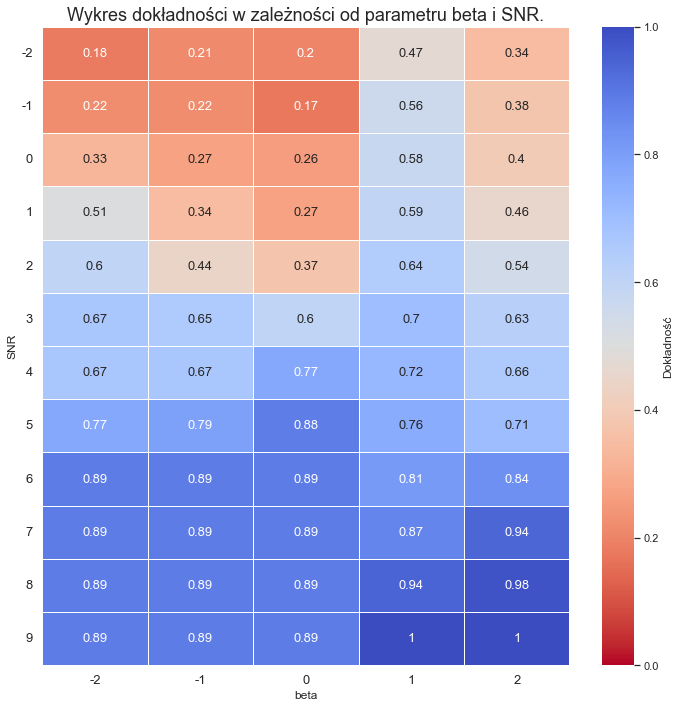

In [101]:
temp = pd.pivot_table(index='SNR', columns='beta', values='accuracy', data = results)

fig = make_heatmap(temp)

In [149]:
fig.savefig(r'vis\noise_snr_beta.png')

## Pointplot 1

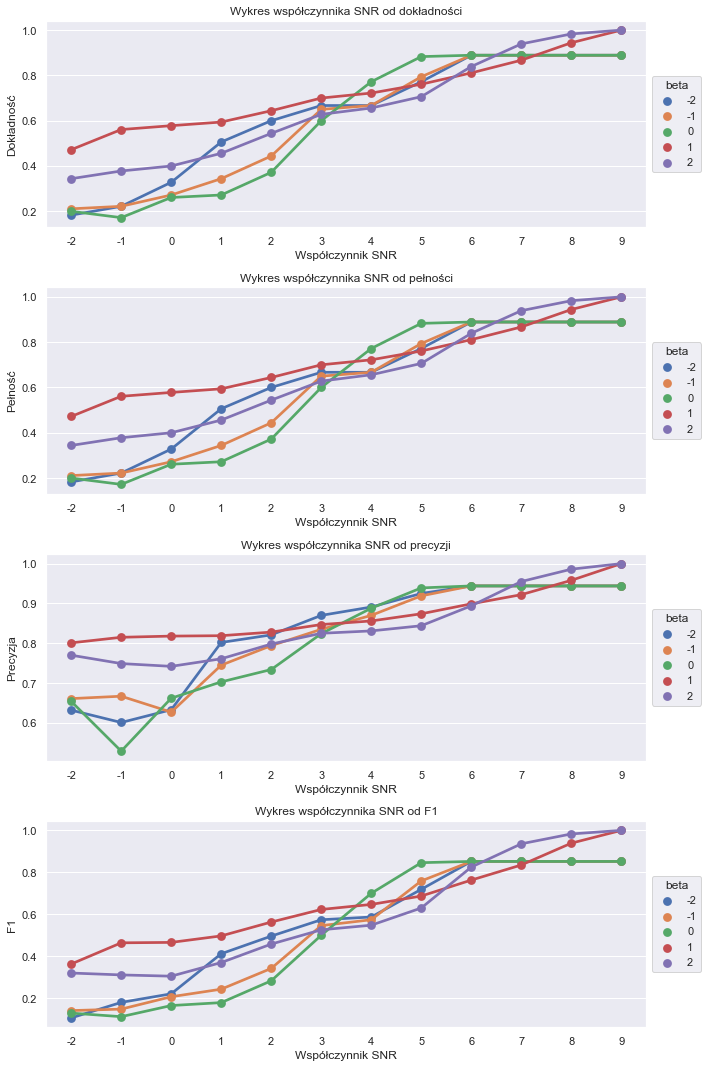

In [56]:
ylabels = ['Dokładność', 'Pełność', 'Precyzja', 'F1']
titles = ['dokładności', 'pełności', 'precyzji', 'F1']

fig = make_pointplot(results, x='SNR', hue='beta', 
               ylabels=ylabels,
               titles=titles,
               scores=scores, 
               legend_title='beta', 
               title_x='współczynnika SNR',
               xlabel="Współczynnik SNR")

In [102]:
fig.savefig(r'vis\point_snr_beta.png')

# Visualizations - Noise on noise

We introduce new method to imporve performance of model in presence of different gaussian noise.

In [102]:
params = {
    'beta': [-2, -1, 0, 1, 2],
    'SNR': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'n_iters' : [15],
    'n_hiddens': [6]
}

results = pd.read_csv(r'results\result_noise_beta_-2_snr_9.csv', 
                     index_col=['Unnamed: 0'])

ints = ['n_iter', 'n_hidden', 'beta', 'SNR']
scores = ['accuracy', 'recall', 'precision', 'F1_score']

results[ints] = results[ints].astype('int64')
for i in scores:
    results[i] = results[i].apply(lambda x: np.round(x, 3))    

## Table 3 SNR = 9

In [103]:
mask = results['SNR']==9
temp = results[mask].groupby(['beta'])[scores].max()
temp

,accuracy,recall,precision,F1_score
beta,,,,
-2,1.000,1.000,1.000,1.000
-1,1.000,1.000,1.000,1.000
0,1.000,1.000,1.000,1.000
1,0.806,0.806,0.887,0.772
2,0.922,0.922,0.943,0.921


### Latex Table

In [59]:
latex_table_generator(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'], [r'$\beta$'])

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{$\beta$} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF}-2 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\cellcolor[HTML]{EFEFEF}-1 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\cellcolor[HTML]{EFEFEF}0 & 1.0 & 1.0 & 1.0 & 1.0\\ \hline 
\cellcolor[HTML]{EFEFEF}1 & 0.806 & 0.806 & 0.887 & 0.772\\ \hline 
\cellcolor[HTML]{EFEFEF}2 & 0.922 & 0.922 & 0.943 & 0.921\\ \hline 
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Table 4 SNR = -2

In [60]:
mask = results['SNR']==-2
temp = results[mask].groupby(['beta'])[scores].max()
temp

,accuracy,recall,precision,F1_score
beta,,,,
-2,0.539,0.539,0.761,0.441
-1,0.372,0.372,0.671,0.270
0,0.494,0.494,0.771,0.411
1,0.489,0.489,0.832,0.454
2,0.272,0.272,0.733,0.341


### Latex table

In [61]:
latex_table_generator(temp, ['Dokładność', 'Pełność', 'Precyzja', 'Miara $F_1$'], [r'$\beta$'])

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{$\beta$} & \textbf{Dokładność} & \textbf{Pełność} & \textbf{Precyzja} & \textbf{Miara $F_1$}\\ \hline 
\cellcolor[HTML]{EFEFEF}-2 & 0.539 & 0.539 & 0.761 & 0.441\\ \hline 
\cellcolor[HTML]{EFEFEF}-1 & 0.372 & 0.372 & 0.671 & 0.27\\ \hline 
\cellcolor[HTML]{EFEFEF}0 & 0.494 & 0.494 & 0.771 & 0.411\\ \hline 
\cellcolor[HTML]{EFEFEF}1 & 0.489 & 0.489 & 0.832 & 0.454\\ \hline 
\cellcolor[HTML]{EFEFEF}2 & 0.272 & 0.272 & 0.733 & 0.341\\ \hline 
\end{tabular}
\caption{}
\label{tab:}
\end{table}


## Heatmap 2

We can create pretty heatmap to present the differentation of our model's accuracy in presence of different noises. 

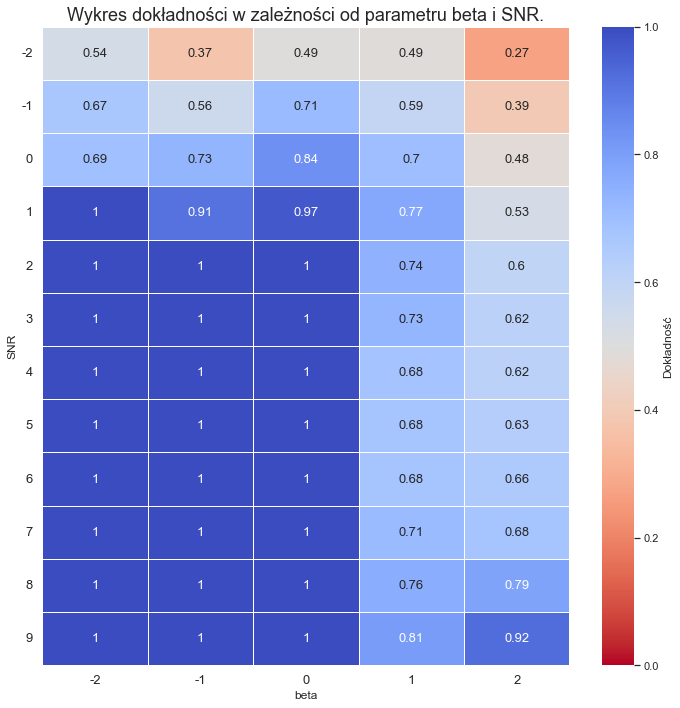

In [104]:
temp = pd.pivot_table(index='SNR', columns='beta', values='accuracy', data = results)
fig = make_heatmap(temp)

In [26]:
fig.savefig(r'vis\noise_on_noise_snr_beta.png')

## Pointplot 2

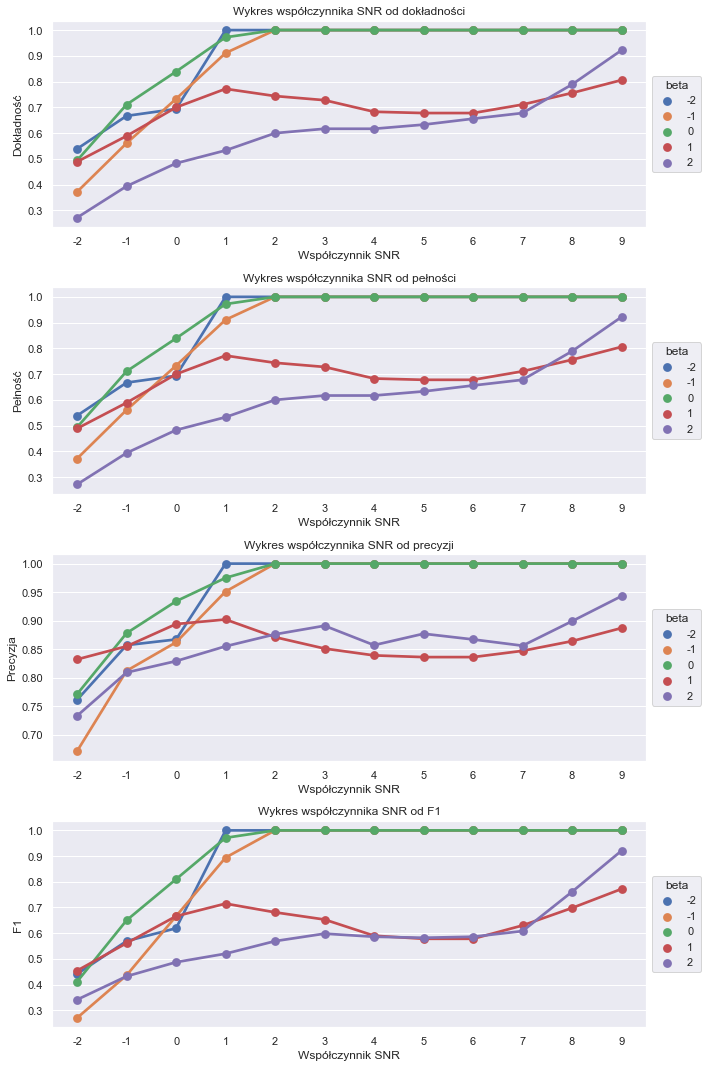

In [64]:
ylabels = ['Dokładność', 'Pełność', 'Precyzja', 'F1']
titles = ['dokładności', 'pełności', 'precyzji', 'F1']

fig = make_pointplot(results, x='SNR', hue='beta', 
               ylabels=ylabels,
               titles=titles,
               scores=scores, 
               legend_title='beta', 
               title_x='współczynnika SNR',
               xlabel="Współczynnik SNR")

In [28]:
fig.savefig(r'vis\point_noise_on_noise_snr_beta.png')

# Visualizations - comparison noise and noise on noise 

We can compare results of base model with the one we trained on noised data.

In [105]:
use_cols = ['Unnamed: 0', 'beta', 'SNR', 'accuracy', 'recall', 'precision',
       'F1_score']
result_on_noise = pd.read_csv(r'results\result_noise_beta_-2_snr_9.csv', 
                     index_col=['Unnamed: 0'], usecols=use_cols)
results = pd.read_csv(r'results\result_noise.csv', 
                     index_col=['Unnamed: 0'], usecols=use_cols)

ints = ['beta', 'SNR']
scores = ['accuracy', 'recall', 'precision', 'F1_score']

result_on_noise[ints] = result_on_noise[ints].astype('int64')
for i in scores:
    result_on_noise[i] = result_on_noise[i].apply(lambda x: np.round(x, 3))    
results[ints] = results[ints].astype('int64')
for i in scores:
    results[i] = results[i].apply(lambda x: np.round(x, 3))    

compare = results.copy()

for score in scores:
    compare[score] = result_on_noise[score] - results[score]

## Accuracy comparison

In [106]:
temp = pd.pivot_table(index='SNR', columns='beta', values='accuracy', data=compare)
temp.style.applymap(highlight_pos) 

beta,-2,-1,0,1,2
SNR,,,,,
-2,0.356000,0.161000,0.294000,0.017000,-0.072000
-1,0.445000,0.339000,0.539000,0.028000,0.016000
0,0.366000,0.461000,0.578000,0.122000,0.083000
1,0.494000,0.567000,0.700000,0.178000,0.077000
2,0.400000,0.556000,0.628000,0.100000,0.056000
3,0.333000,0.350000,0.400000,0.028000,-0.011000
4,0.333000,0.333000,0.228000,-0.039000,-0.039000
5,0.228000,0.206000,0.117000,-0.083000,-0.073000
6,0.111000,0.111000,0.111000,-0.133000,-0.183000


### Latex table

In [107]:
latex_table_generator_comparison(temp)

\begin{table}[]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rowcolor[HTML]{C0C0C0} \textbf{$\beta$} & \textbf{-2} & \textbf{-1} & \textbf{0} & \textbf{1} & \textbf{2} \\ \hline
\rowcolor[HTML]{C0C0C0}$\mathbf{\mathit{SNR}_{dB}}$ }  & \multicolumn{5}{c|}{}\\ \hline 
\cellcolor[HTML]{EFEFEF}-2 & \cellcolor[HTML]{9AFF99}0.356 & \cellcolor[HTML]{9AFF99}0.161 & \cellcolor[HTML]{9AFF99}0.294 & \cellcolor[HTML]{9AFF99}0.017 & \cellcolor[HTML]{FFCCC9}-0.072\\ \hline 
\cellcolor[HTML]{EFEFEF}-1 & \cellcolor[HTML]{9AFF99}0.445 & \cellcolor[HTML]{9AFF99}0.339 & \cellcolor[HTML]{9AFF99}0.539 & \cellcolor[HTML]{9AFF99}0.028 & \cellcolor[HTML]{9AFF99}0.016\\ \hline 
\cellcolor[HTML]{EFEFEF}0 & \cellcolor[HTML]{9AFF99}0.366 & \cellcolor[HTML]{9AFF99}0.461 & \cellcolor[HTML]{9AFF99}0.578 & \cellcolor[HTML]{9AFF99}0.122 & \cellcolor[HTML]{9AFF99}0.083\\ \hline 
\cellcolor[HTML]{EFEFEF}1 & \cellcolor[HTML]{9AFF99}0.494 & \cellcolor[HTML]{9AFF99}0.567 & \cellcolor[HTML]{9AFF99}0.7 & \cellcolor[HTML

## Recall Comparison

In [108]:
temp = pd.pivot_table(index='SNR', columns='beta', values='recall', data=compare)
temp.style.applymap(highlight_pos) 

beta,-2,-1,0,1,2
SNR,,,,,
-2,0.356000,0.161000,0.294000,0.017000,-0.072000
-1,0.445000,0.339000,0.539000,0.028000,0.016000
0,0.366000,0.461000,0.578000,0.122000,0.083000
1,0.494000,0.567000,0.700000,0.178000,0.077000
2,0.400000,0.556000,0.628000,0.100000,0.056000
3,0.333000,0.350000,0.400000,0.028000,-0.011000
4,0.333000,0.333000,0.228000,-0.039000,-0.039000
5,0.228000,0.206000,0.117000,-0.083000,-0.073000
6,0.111000,0.111000,0.111000,-0.133000,-0.183000


## Precision Comparison

In [109]:
temp = pd.pivot_table(index='SNR', columns='beta', values='precision', data=compare)
temp.style.applymap(highlight_pos) 

beta,-2,-1,0,1,2
SNR,,,,,
-2,0.129000,0.010000,0.117000,0.031000,-0.037000
-1,0.256000,0.145000,0.349000,0.040000,0.060000
0,0.234000,0.235000,0.272000,0.076000,0.087000
1,0.198000,0.206000,0.272000,0.083000,0.094000
2,0.179000,0.206000,0.266000,0.043000,0.078000
3,0.130000,0.165000,0.176000,0.004000,0.066000
4,0.109000,0.130000,0.112000,-0.017000,0.026000
5,0.075000,0.081000,0.061000,-0.038000,0.033000
6,0.056000,0.056000,0.056000,-0.063000,-0.027000


## F1 score comparison

In [110]:
temp = pd.pivot_table(index='SNR', columns='beta', values='F1_score', data=compare)
temp.style.applymap(highlight_pos) 

beta,-2,-1,0,1,2
SNR,,,,,
-2,0.335000,0.129000,0.282000,0.091000,0.021000
-1,0.389000,0.288000,0.538000,0.097000,0.121000
0,0.398000,0.459000,0.645000,0.200000,0.182000
1,0.588000,0.651000,0.792000,0.218000,0.150000
2,0.504000,0.658000,0.717000,0.118000,0.111000
3,0.426000,0.454000,0.500000,0.030000,0.072000
4,0.413000,0.426000,0.300000,-0.057000,0.038000
5,0.281000,0.241000,0.154000,-0.109000,-0.048000
6,0.148000,0.148000,0.148000,-0.185000,-0.239000
